In [144]:
%matplotlib inline
import os
import json
import codecs
import numpy as np
import matplotlib.pyplot as plt
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.plotting.seismicity.catalogue_plots as cp

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector


In [97]:
# Alkan Hotel, Marmaris, Turkey
target_lon = 28.2520426
target_lat = 36.8429408

# load fault data in JSON format
source_file = "Eastern_Mediterranean_Fault_Traces.geojson"
DATA = json.load(open(source_file, "r"))
DATA = OrderedDict([(dat["properties"]["IDSOURCE"], dat) 
                    for dat in DATA["features"]])

In [98]:
# not actually using this code but it's a nice demo
def show_fault_properties(flt_id):
    fault = DATA[flt_id]
    # pretty print
    print "ID = %s" % fault["properties"]["IDSOURCE"]
    print "Name = %s" % fault["properties"]["SOURCENAME"]
    print "Trace (long. lat.):"
    for crd in fault["geometry"]["coordinates"]:
        print "    %.6f %.6f" % (crd[0], crd[1])
    print "Dip = %s - %s" % (str(fault["properties"]["DIPMIN"]), 
                             str(fault["properties"]["DIPMAX"]))
    print "Rake = %s - %s" % (str(fault["properties"]["RAKEMIN"]), 
                              str(fault["properties"]["RAKEMAX"]))
    print "Upper Seismogenic Depth = %s km" % \
        (str(fault["properties"]["MINDEPTH"]))
    print "Lower Seismogenic Depth = %s km" % \
        (str(fault["properties"]["MAXDEPTH"]))
    print "Slip Rate = %s - %s mm/yr" % \
        (str(fault["properties"]["SRMIN"]), 
         str(fault["properties"]["SRMAX"]))

In [99]:
show_fault_properties('TRCS996')

ID = TRCS996
Name = NAF - Marmara-Saros
Trace (long. lat.):
    28.026022 40.802240
    27.881072 40.811477
    27.710143 40.808178
    27.575641 40.803779
    27.501385 40.796080
    27.424327 40.777384
    27.336198 40.752120
    27.206820 40.715472
    27.136914 40.699998
    27.067007 40.682895
    26.987711 40.655205
    26.900067 40.616927
    26.848880 40.595414
    26.681833 40.532155
    26.585053 40.491599
    26.488272 40.451043
    26.321028 40.371284
    26.200499 40.315794
    26.085589 40.272354
    25.926659 40.247307
    25.773818 40.212031
    25.628512 40.161581
    25.524078 40.123521
    25.389534 40.092251
    25.251618 40.053514
    25.081501 40.006679
    25.005397 39.984839
Dip = 55 - 90
Rake = 180 - 225
Upper Seismogenic Depth = 0.0 km
Lower Seismogenic Depth = 19.0 km
Slip Rate = 26.5 - 28.8881 mm/yr


In [100]:
# loop over faults; compute and append statistics of interest
mu = 30e9 # [Pa] dummy value for estimate of moment rate
print "%d faults total" % len(DATA)
print "Adding some statistics ..."
for fault in DATA:
    fault_lonlat = np.array(DATA[fault]["geometry"]["coordinates"])
    min_depth = np.array(DATA[fault]["properties"]["MINDEPTH"])
    s_min = DATA[fault]["properties"]["SRMIN"]
    s_max = DATA[fault]["properties"]["SRMAX"]
    d_min = DATA[fault]["properties"]["MINDEPTH"]
    d_max = DATA[fault]["properties"]["MAXDEPTH"]
    phi_min = DATA[fault]["properties"]["DIPMIN"]
    phi_max = DATA[fault]["properties"]["DIPMAX"]
    
    L_max = geo.distance(fault_lonlat[0,0], fault_lonlat[0,1], 0, 
                    fault_lonlat[-1,0], fault_lonlat[-1,1], 0)
    R_all = geo.distance(target_lon, target_lat, 0, 
                    fault_lonlat[:,0], fault_lonlat[:,1], min_depth)
    R_min = np.min(R_all)
    R_max = np.max(R_all)
    R_mid = (R_max + R_min)/2
    W_max = (d_max - d_min)/np.abs(np.sin(phi_min))
    W_mid = (d_max - d_min)/np.abs(np.sin((phi_max + phi_min)/2))
    s_mid = (s_max + s_min)/2
    L_mid = L_max/2
    M0_rate_max = mu*L_max*1e3*W_max*1e3*s_max*1e-3
    M0_rate_mid = mu*L_mid*1e3*W_mid*1e3*s_mid*1e-3
    M0_rate_hybrid = mu*L_max*1e3*W_mid*1e3*s_mid*1e-3
    danger = M0_rate_hybrid/R_min
    
    DATA[fault]["statistics"] = {
        "R_min": R_min,
        "R_max": R_max,
        "R_mid": R_mid,
        "L_max": L_max,
        "W_max": W_max,
        "W_mid": W_mid,
        "s_mid": s_mid,
        "M0_rate_max": M0_rate_max,
        "M0_rate_mid": M0_rate_mid,
        "M0_rate_hybrid": M0_rate_mid,
        "danger": danger,
    }

925 faults total
Adding some statistics ...


In [101]:
# a function for filtering the fault list by "danger"
def pick_dangerous_faults(data, key, n, quiet=False):
    
    if key == 'R_min':
        reverse = False
    else:
        reverse = True
        
    data_sorted = sorted(data.items(), 
                key=lambda item: item[1]["statistics"][key], 
                                     reverse=reverse)

    top = OrderedDict(data_sorted[:n])

    if not quiet:
        print "  fault, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger?"
    for (key, fault) in top.items():
        s_max = fault["properties"]["SRMAX"]

        R_min = fault["statistics"]["R_min"]
        L_max = fault["statistics"]["L_max"]
        W_mid = fault["statistics"]["W_mid"]
        s_mid = fault["statistics"]["s_mid"]
        M0_rate_max = fault["statistics"]["M0_rate_max"]
        M0_rate_mid = fault["statistics"]["M0_rate_mid"]
        M0_rate_hybrid = fault["statistics"]["M0_rate_hybrid"]
        danger = fault["statistics"]["danger"]

        if not quiet:
            print "%s, %5.1f, %5.1f, %5.1f, %5.1f, %7.1e, %7.1e"  % \
                (key, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger)
        
    return top

In [102]:
template_file = "SimpleFaultTemplate.xml" 
with open(template_file, 'r') as myfile:
    template_string = myfile.read()
template_string

'<?xml version=\'1.0\' encoding=\'utf-8\'?>\n<nrml xmlns:gml="http://www.opengis.net/gml"\n      xmlns="http://openquake.org/xmlns/nrml/0.4">\n\n    <sourceModel name="$SOURCEMODELNAME">\n\n        <simpleFaultSource id="$IDSOURCE" name="$SOURCENAME" tectonicRegion="$REGION">\n            <simpleFaultGeometry>\n                <gml:LineString>\n                    <gml:posList>\n$TRACE\n                    </gml:posList>\n                </gml:LineString>\n                <dip>$DIP</dip>\n                <upperSeismoDepth>$MINDEPTH</upperSeismoDepth>\n                <lowerSeismoDepth>$MAXDEPTH</lowerSeismoDepth>\n            </simpleFaultGeometry>\n            <magScaleRel>$SCALEREL</magScaleRel>\n            <ruptAspectRatio>$ASPECTRATIO</ruptAspectRatio>\n            <$MFD/>\n            <rake>$RAKE</rake>\n        </simpleFaultSource>\n\n    </sourceModel>\n</nrml>\n'

In [103]:
def fault_json_to_xml(fault_json):

    fault_file_list = []
    region = "Active Shallow Crust"
    coord_format = "                        %10.6f %10.6f\n"
    scaling_relation = "WC1994"
    aspect_ratio = 2.0
    MFD = 'truncGutenbergRichterMFD aValue="4.0" bValue="1.0" minMag="5.0" maxMag="8.0"'

    for (key, fault) in fault_json.items():

        fault_lonlat = np.array(fault["geometry"]["coordinates"])
        coord_string = [(coord_format % tuple(coords)) for coords in fault_lonlat]
        coord_string = (''.join(coord_string))[:-1]
        dip_min = fault["properties"]["DIPMIN"]
        dip_max = fault["properties"]["DIPMAX"]
        rake_min = fault["properties"]["RAKEMIN"]
        rake_max = fault["properties"]["RAKEMAX"]

        with open(template_file, 'r') as myfile:
            template_string = myfile.read()

        template = Template(template_string)
        output_string = template.substitute(
            IDSOURCE=key,
            SOURCEMODELNAME="$SOURCEMODELNAME",
            SOURCENAME=fault["properties"]["SOURCENAME"],
            REGION=region,
            TRACE=coord_string,
            DIP="%.1f" % ((dip_min + dip_max)/2),
            MINDEPTH="%.1f" % fault["properties"]["MINDEPTH"],
            MAXDEPTH="%.1f" % fault["properties"]["MAXDEPTH"],
            SCALEREL=scaling_relation,
            ASPECTRATIO="%.3g" % aspect_ratio,
            MFD=MFD,
            RAKE="%.1f" % ((rake_min + rake_max)/2),
        )

        output_file = key + '.xml'

        with open(output_file, 'w') as myfile:
            myfile.write(output_string)

        fault_file_list.append(output_file)
                
    return fault_file_list

In [104]:
def concat_xml_faults(fault_xml_list, source_model_name, output_xml):
    
    joint_string = '\n    </sourceModel>\n' \
        + '</nrml>\n<?xml version=\'1.0\' encoding=\'utf-8\'?>\n' \
        + '<nrml xmlns:gml="http://www.opengis.net/gml"\n' \
        + '      xmlns="http://openquake.org/xmlns/nrml/0.4">\n\n' \
        + '    <sourceModel name="$SOURCEMODELNAME">\n'

    # read and concatenate all of the files
    faults = ''
    for file_name in fault_xml_list:
        with open(file_name, 'r') as myfile:
            fault = myfile.read()
        faults = faults + fault

    # remove redundent start/end XML 
    faults = faults.replace(joint_string,'')

    # give the model a name
    template = Template(faults)
    output_string = template.substitute(
        SOURCEMODELNAME=source_model_name)

    # ship it
    print "Writing results to ", output_xml
    with open(output_xml, 'w') as myfile:
        myfile.write(output_string)


In [187]:
# other faults to add
subduction_fault_file = "HellenicArc.xml"
n_faults = 30

In [188]:
# write "dangerous" source model
dangerous_sources_file = "MarmarisDangerousSources%d.xml" \
    % (n_faults + 1)
sources_name = "Top %d sources potentially dangerous to Marmaris" \
    % (n_faults + 1)

faults = pick_dangerous_faults(DATA, 'danger', n_faults, quiet=False)
fault_file_list = fault_json_to_xml(faults)
fault_file_list.append(subduction_fault_file)

concat_xml_faults(fault_file_list, sources_name, dangerous_sources_file)

  fault, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger?
TRCS996, 425.3, 271.5,  74.9,  27.7, 8.4e+18, 4.0e+16
TRCS394,  21.6,  31.7,  42.6,   5.4, 1.1e+17, 1.0e+16
TRCS006, 623.5, 293.0,  26.6,  25.0, 2.9e+18, 9.4e+15
TRCS391,  23.1,  49.6,  15.7,   9.0, 1.1e+17, 9.1e+15
TRCS331, 116.3, 119.9,  49.5,   4.3, 3.8e+17, 6.6e+15
TRCS271,  77.7,  38.9,  57.2,   7.4, 2.5e+17, 6.4e+15
TRCS322, 157.5, 114.0,  49.5,   5.7, 4.8e+17, 6.1e+15
GRCS999, 427.1,  60.1,  51.1,  28.0, 1.3e+18, 6.0e+15
TRCS003, 773.4, 353.7,  18.3,  22.4, 2.2e+18, 5.6e+15
TRCS393,  48.5,  21.2,  42.6,   9.8, 1.3e+17, 5.5e+15
TRCS013, 438.9,  99.1,  27.8,  27.0, 1.1e+18, 5.1e+15
TRCS007, 499.3, 165.1,  20.7,  24.2, 1.2e+18, 5.0e+15
TRCS390, 239.7, 254.4,  38.9,   3.9, 5.8e+17, 4.9e+15
TRCS268,  85.4,  36.3,  49.5,   7.4, 2.0e+17, 4.7e+15
GRCS603, 706.4, 116.5,  68.9,  12.5, 1.5e+18, 4.3e+15
TRCS913,  21.3,  84.2,  19.6,   1.8, 4.3e+16, 4.1e+15
TRCS023, 397.5,  95.0, 102.2,   5.3, 7.8e+17, 3.9e+15
TRCS001, 1111.9,  51.

In [189]:
# write "nearby" source model
nearby_sources_file = "MarmarisNearbySources%d.xml" \
    % (n_faults + 1)
sources_name = "Top %d sources nearest to Marmaris.xml" \
    % (n_faults + 1)

faults = pick_dangerous_faults(DATA, 'R_min', n_faults, quiet=False)
fault_file_list = fault_json_to_xml(faults)
fault_file_list.append(subduction_fault_file)

concat_xml_faults(fault_file_list, sources_name, nearby_sources_file)

  fault, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger?
TRCS913,  21.3,  84.2,  19.6,   1.8, 4.3e+16, 4.1e+15
TRCS394,  21.6,  31.7,  42.6,   5.4, 1.1e+17, 1.0e+16
TRCS391,  23.1,  49.6,  15.7,   9.0, 1.1e+17, 9.1e+15
TRCS396,  38.4,  51.9,  13.1,   5.5, 5.6e+16, 2.9e+15
TRCS413,  40.1,  31.2,  13.1,   1.0, 6.3e+15, 3.1e+14
TRCS414,  41.2,  15.9,  13.1,   1.0, 3.2e+15, 1.6e+14
TRCS392,  43.3,  16.4,  16.8,   4.9, 2.0e+16, 9.4e+14
TRCS412,  48.0,  11.5,  13.1,   1.0, 2.3e+15, 9.7e+13
TRCS393,  48.5,  21.2,  42.6,   9.8, 1.3e+17, 5.5e+15
TRCS397,  50.6,  22.0,  13.1,   1.0, 4.4e+15, 1.8e+14
TRCS415,  58.8,  38.6,  13.1,   1.0, 7.8e+15, 2.7e+14
TRCS398,  59.0,  10.1,  13.1,   1.0, 2.1e+15, 7.0e+13
TRCS395,  63.3,  12.3,  42.6,   5.4, 4.2e+16, 1.3e+15
TRCS338,  70.1,  17.1,  39.4,   5.8, 5.9e+16, 1.7e+15
TRCS271,  77.7,  38.9,  57.2,   7.4, 2.5e+17, 6.4e+15
GRCS965,  77.8,  44.2,  19.6,   3.0, 3.9e+16, 1.0e+15
TRCS293,  78.6,  22.9,  53.4,   1.3, 2.4e+16, 6.1e+14
TRCS268,  85.4,  36.3

In [190]:
catalogue_filename = '../seismicity/output_homogenized_Marmaris.csv'
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute  is not a recognised catalogue key
Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  0.75
Maximum magnitude:  7.6
Number of events:  30006
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


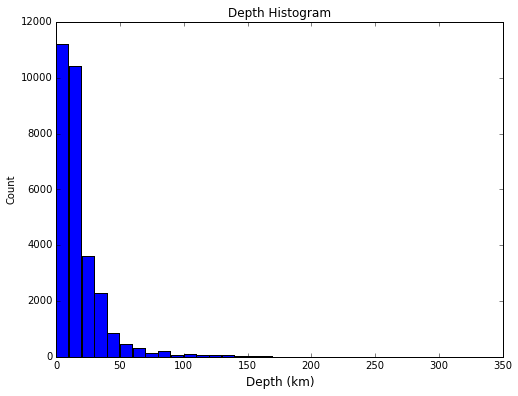

In [191]:
cp.plot_depth_histogram(catalogue, 10)

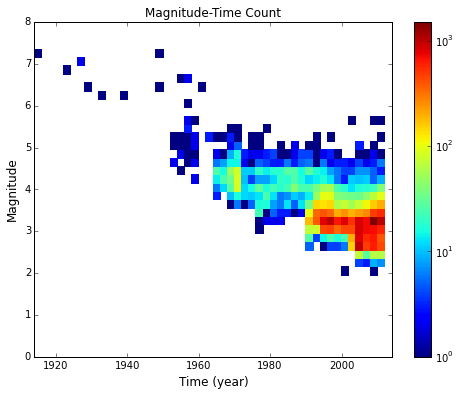

In [192]:
cp.plot_magnitude_time_density(catalogue, 0.2, 2)

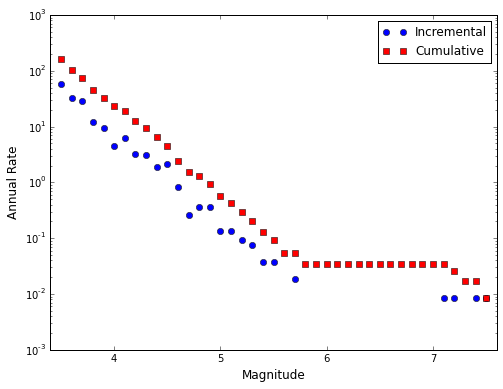

In [193]:
completeness_table_a = np.array([[1992, 3.5],
                                 [1978, 4.0], 
                                 [1963, 5.0],
                                 [1900, 7.0]]) 
cp.plot_observed_recurrence(catalogue, completeness_table_a, 0.1)

In [194]:
# Map configuration
span = 1 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

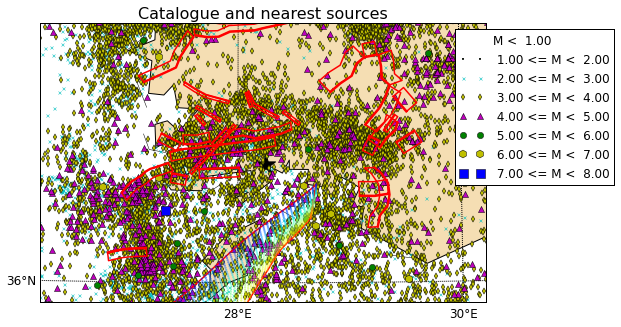

In [195]:
# Creating a basemap 
basemap1 = HMTKBaseMap(map_config, 'Catalogue and nearest sources')

# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)

# Reading the models 
parser = nrmlSourceModelParser(nearby_sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)

# Add target
basemap1.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k', zorder=6)

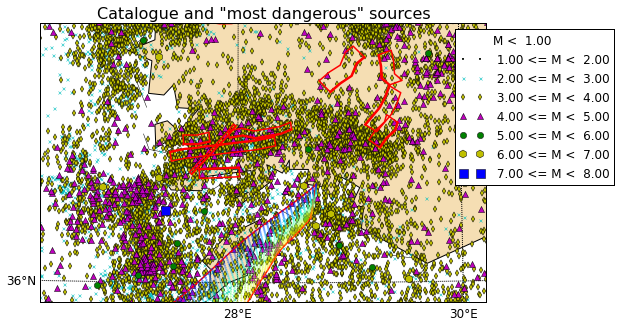

In [196]:
# Creating a basemap 
basemap1 = HMTKBaseMap(map_config, 'Catalogue and "most dangerous" sources')

# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)

# Reading the models 
parser = nrmlSourceModelParser(dangerous_sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5) 

In [197]:
selector = CatalogueSelector(catalogue, create_copy=True)

In [198]:
for source in source_model.sources:
    if isinstance(source, src.area_source.mtkAreaSource): 
        source.select_catalogue(selector)
        print 'Area source %s, name %s, # of events %8.0f' % (
            source.id, source.name, source.catalogue.get_number_events())
        #subcatalogue_area = selector.    

In [200]:
d_km = 10*np.ones_like(source_model.sources)
d_km[-1] = 30
for i, source in enumerate(source_model.sources):
    if isinstance(source, src.simple_fault_source.mtkSimpleFaultSource): 
        source.select_catalogue(selector, d_km[i])
    elif isinstance(source, src.complex_fault_source.mtkComplexFaultSource): 
        source.select_catalogue(selector, d_km[i]) 
        
    print '%s: %s, %d events wihin %g km' % (
        source.id, source.name, source.catalogue.get_number_events(), d_km[i])

TRCS996: NAF - Marmara-Saros, 0 events wihin 10 km
TRCS394: Datca Horst North Boundary 1, 305 events wihin 10 km
TRCS006: NAF - 1943 Tosya Ladik, 0 events wihin 10 km
TRCS391: Gokova Oren Fault Zone 1, 669 events wihin 10 km
TRCS331: Buyuk Menderes Graben North Boundary 2, 625 events wihin 10 km
TRCS271: Golgelidag Horst West Boundary - Tavas, 71 events wihin 10 km
TRCS322: Gediz Graben South Boundary, 221 events wihin 10 km
GRCS999: Lemnos, 0 events wihin 10 km
TRCS003: NAF - 1939 Earthquake, 0 events wihin 10 km
TRCS393: Gokova Oren Fault Zone 3, 494 events wihin 10 km
TRCS013: NAF - Eastern Marmara, 0 events wihin 10 km
TRCS007: NAF - 1944 Bolu Gerede, 0 events wihin 10 km
TRCS390: Aksu Thrust, 506 events wihin 10 km
TRCS268: Golgelidag Horst East Boundary - Akalan, 304 events wihin 10 km

/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS007 (NAF - 1944 Bolu Gerede) has fewer than 5 events
  % (self.id, self.name))
/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source GRCS603 (Kephallonia) has fewer than 5 events
  % (self.id, self.name))



GRCS603: Kephallonia, 0 events wihin 10 km
TRCS913: Ula-Oren, 1337 events wihin 10 km
TRCS023: NAF - Gemlik Bandirma, 0 events wihin 10 km

/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS023 (NAF - Gemlik Bandirma) has fewer than 5 events
  % (self.id, self.name))
/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS001 (NAF - 1949 Elmali Earthquake) has fewer than 5 events
  % (self.id, self.name))



TRCS001: NAF - 1949 Elmali Earthquake, 0 events wihin 10 km
TRCS133: Bitlis Thrust Zone - Ergani Cungus, 0 events wihin 10 km
TRCS330: Buyuk Menderes Graben North Boundary 1, 919 events wihin 10 km

/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS133 (Bitlis Thrust Zone - Ergani Cungus) has fewer than 5 events
  % (self.id, self.name))
/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS022 (NAF - Geyve Gemlik) has fewer than 5 events
  % (self.id, self.name))



TRCS022: NAF - Geyve Gemlik, 0 events wihin 10 km
TRCS033: NAF - Edremit Fault, 6 events wihin 10 km
TRCS027: NAF - Etili Fault, 0 events wihin 10 km
TRCS396: Gokova Transfer Fault, 811 events wihin 10 km
TRCS273: Cameli Fault Zone - Cameli, 909 events wihin 10 km

/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS027 (NAF - Etili Fault) has fewer than 5 events
  % (self.id, self.name))
/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS059 (EAF - East Hatay Fault) has fewer than 5 events
  % (self.id, self.name))



TRCS059: EAF - East Hatay Fault, 0 events wihin 10 km
TRCS269: Golgelidag Horst East Boundary - Acipayam, 102 events wihin 10 km
GRCS510: Xylokastro, 0 events wihin 10 km

/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source GRCS510 (Xylokastro) has fewer than 5 events
  % (self.id, self.name))
/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS012 (NAF - 1999 Izmit Earthquake) has fewer than 5 events
  % (self.id, self.name))



TRCS012: NAF - 1999 Izmit Earthquake, 0 events wihin 10 km
TRCS054: EAF - Celikhan (1893 ) 1, 0 events wihin 10 km
HELL001: Hellenic Arc, 6126 events wihin 30 km


/home/nick/src/python/GEM/hmtk/hmtk/sources/simple_fault_source.py:240: UserWarning: Source TRCS054 (EAF - Celikhan (1893 ) 1) has fewer than 5 events
  % (self.id, self.name))


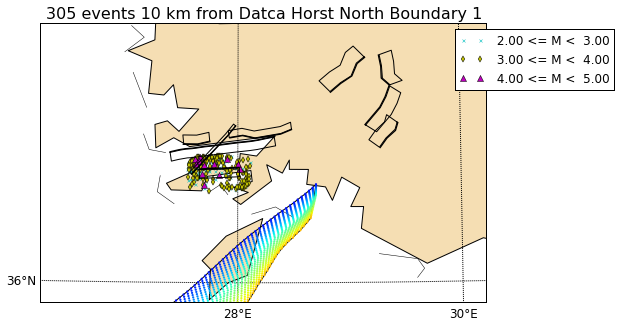

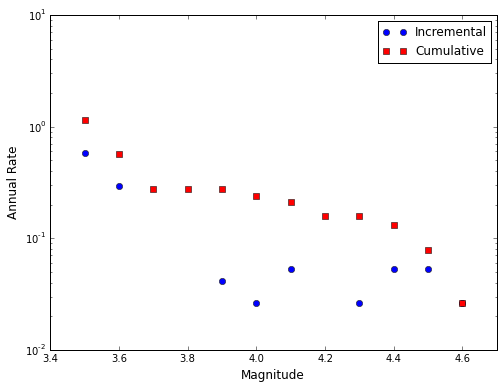

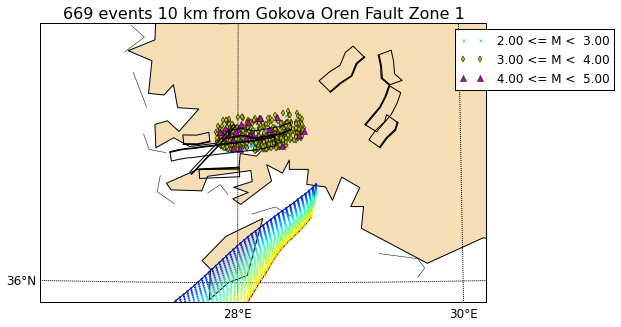

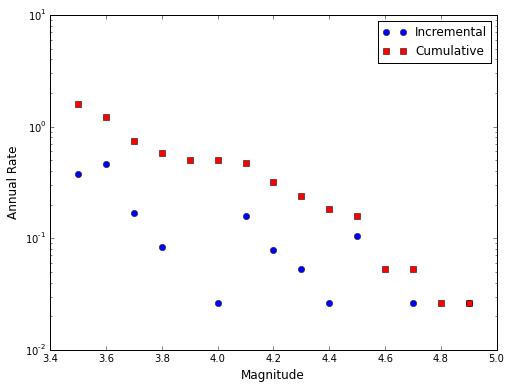

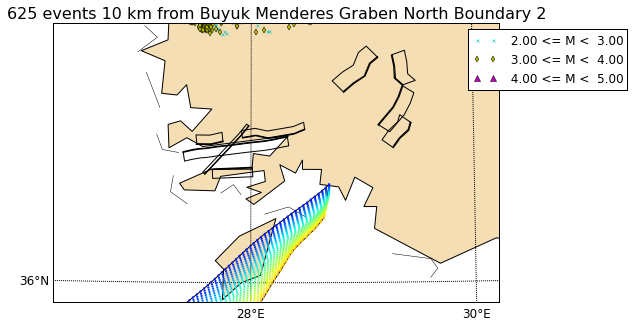

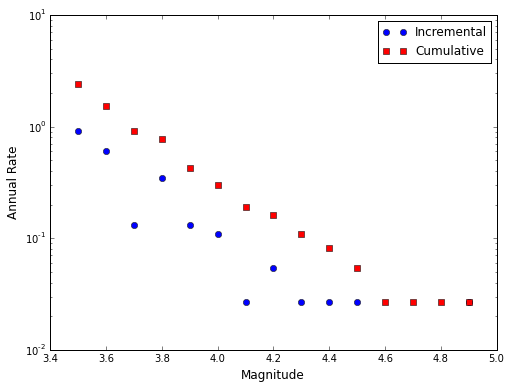

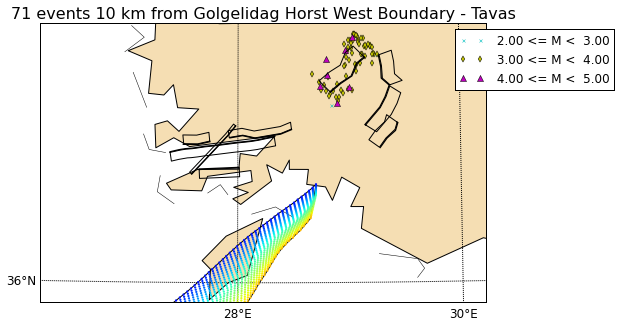

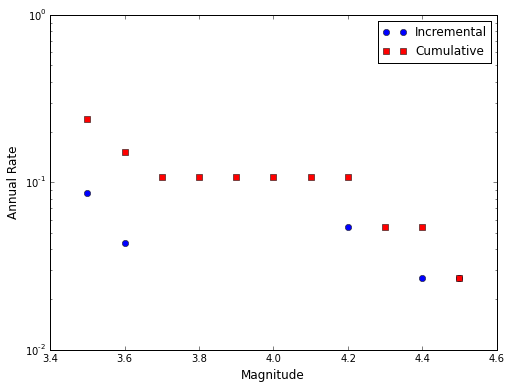

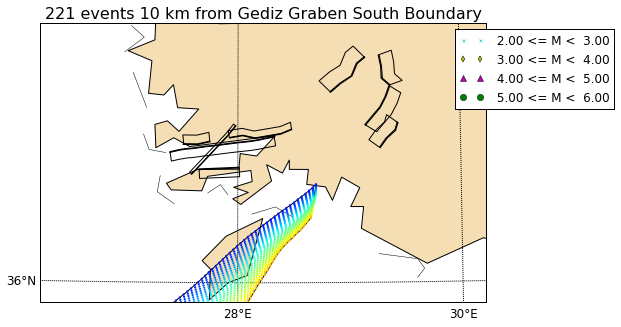

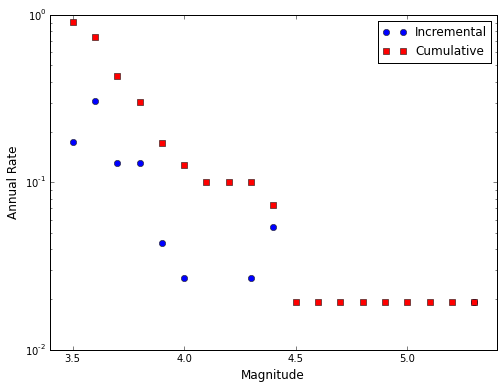

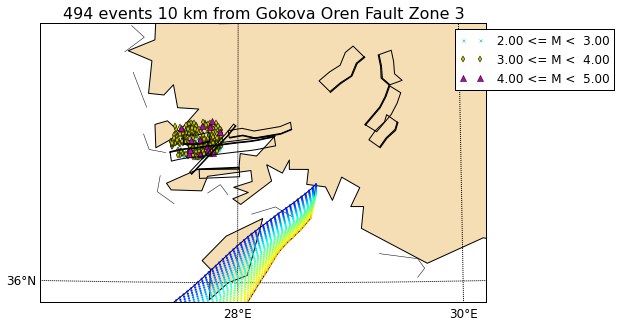

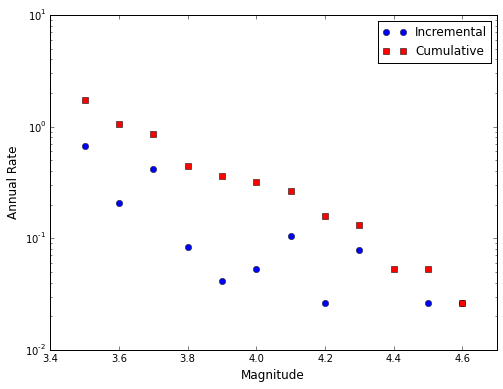

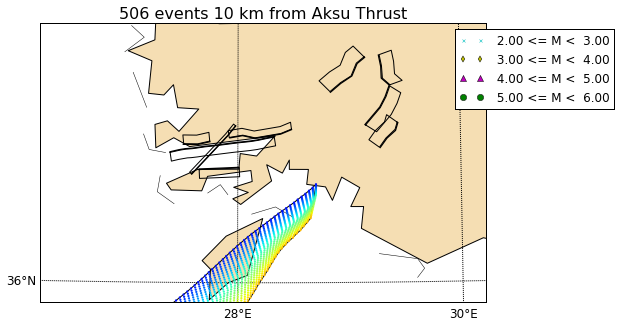

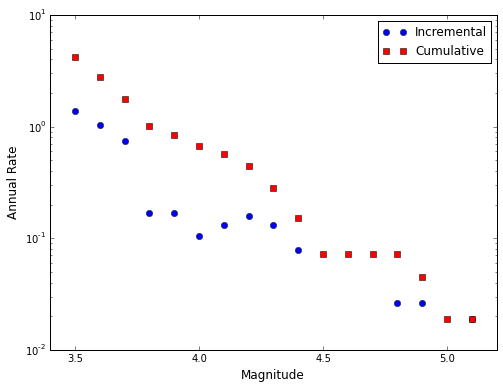

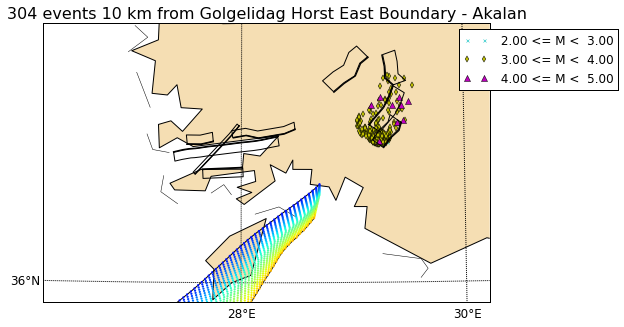

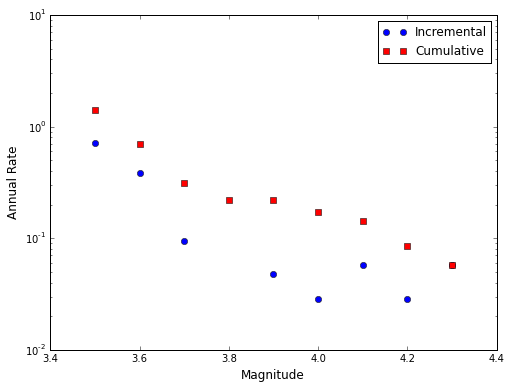

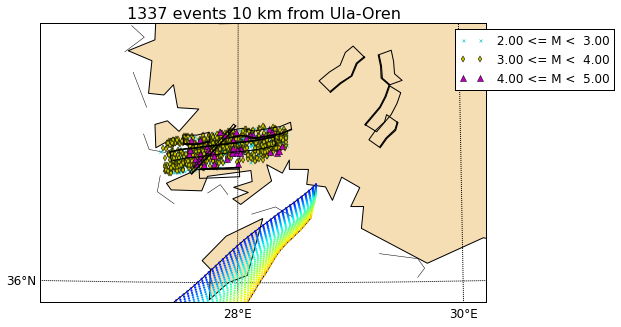

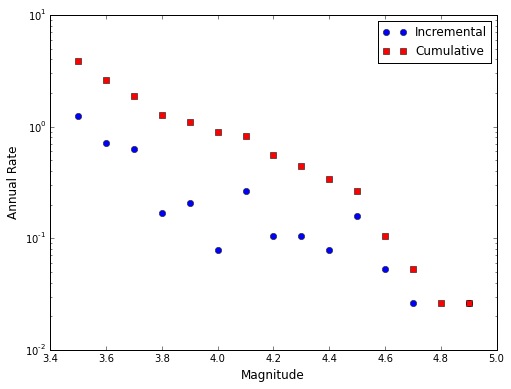

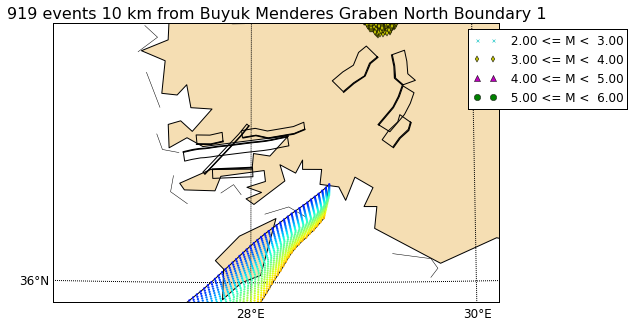

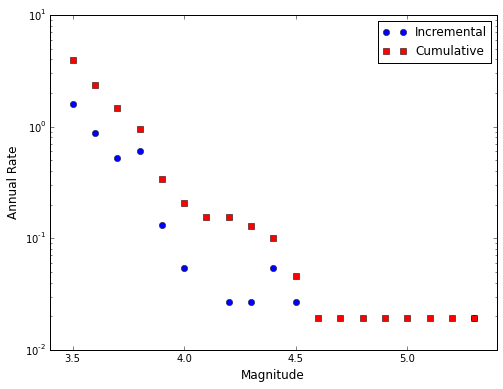

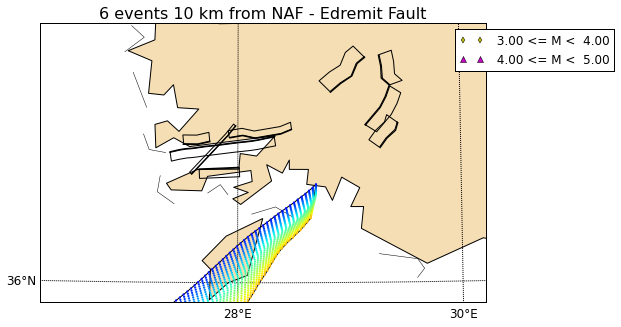

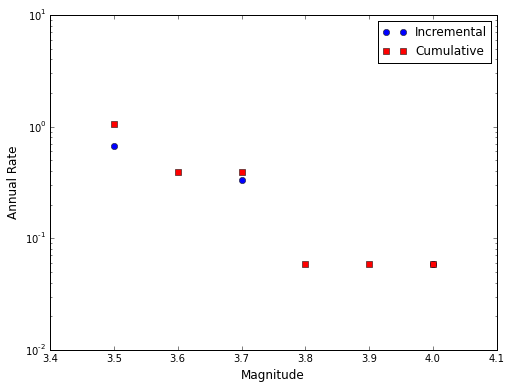

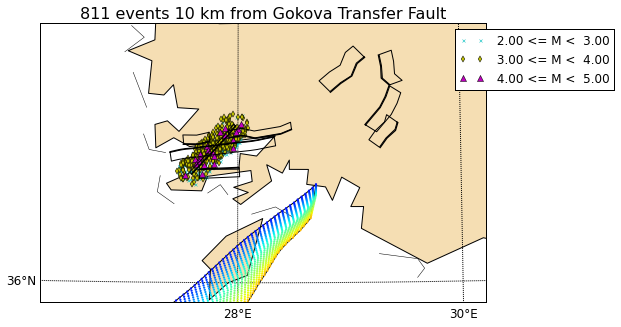

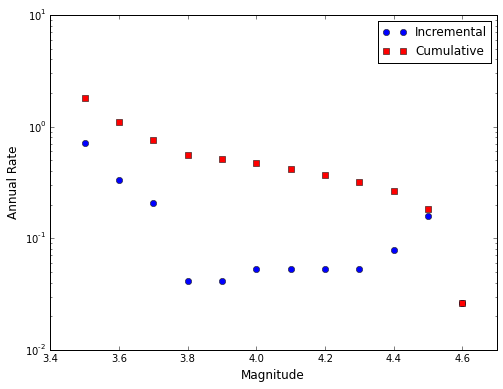

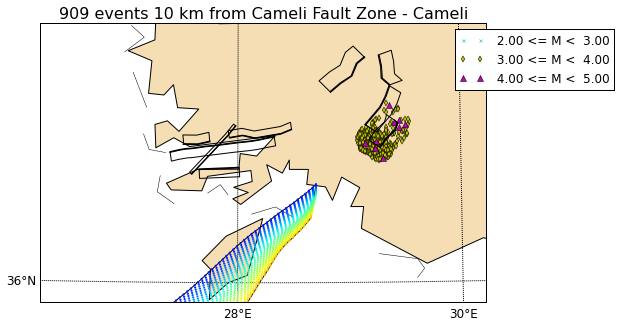

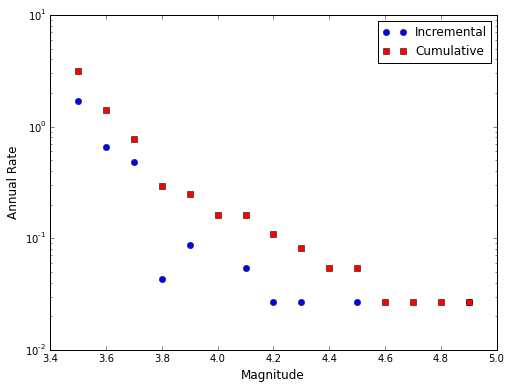

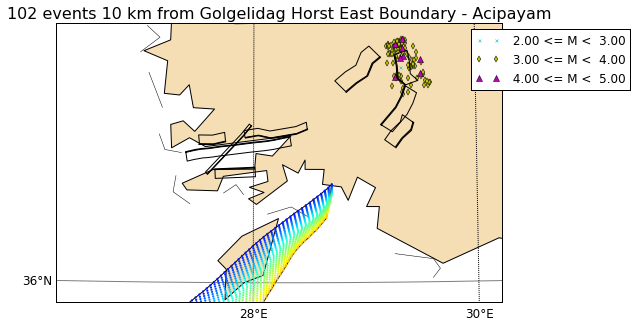

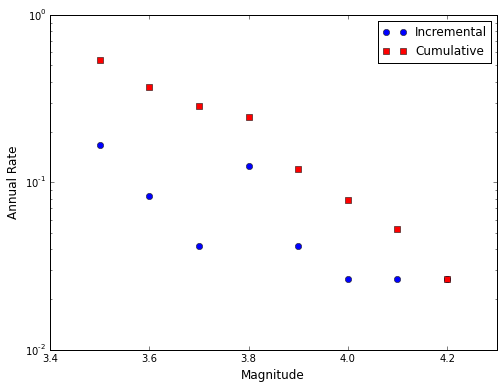

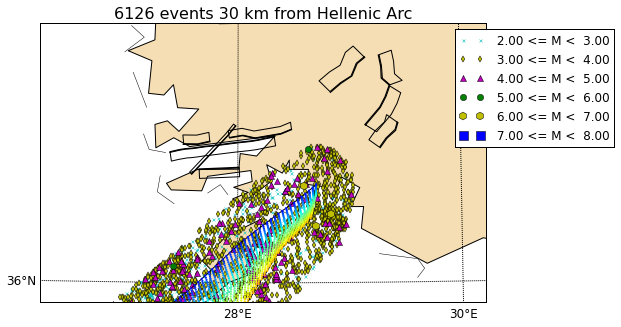

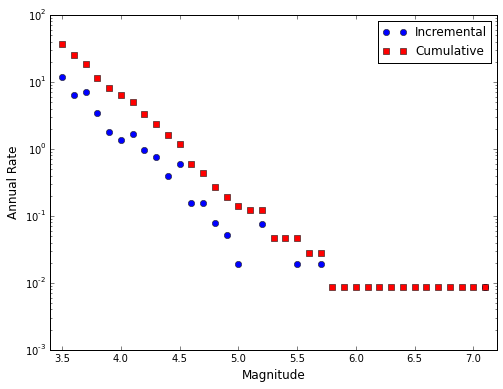

In [202]:
for i, source in enumerate(source_model.sources):
    n_events = source.catalogue.get_number_events()
    if n_events < 5: continue
    basemap = HMTKBaseMap(
        map_config, '%d events %d km from %s' % (n_events, d_km[i], source.name))
    basemap.add_catalogue(source.catalogue, overlay=True)
    basemap.add_source_model(source_model, area_border='k-')
    
    cp.plot_observed_recurrence(source.catalogue, completeness_table_a, 0.1)